# Inhaltsverzeichnis

| Abschnitt | Unterabschnitt |
|-----------|----------------|
| **[LSTM Monatsmodell trainiert ohne das Jahr 2015 (später als Testdaten in der Prognose verwendet)](#lstm-monatsmodell-trainiert-ohne-das-jahr-2015-(spaeter-als-testdaten-in-der-prognose-verwendet))** | |
| **[Prognosejahr 2015](#prognosejahr-2015)** | |
| **[Gesamttabelle der Fehlerindizes aller Modelle.](#gesamttabelle-der-fehlerindizes-aller-modelle.)** | |


## LSTM Monatsmodell trainiert ohne das Jahr 2015 (später als Testdaten in der Prognose verwendet)


In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import json

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Filter out data after 2015
data = data[data['YearMonth'] < '2015-01-01']

# Add logarithm of monthly fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Monthly Fire Counts'])  # log1p to handle zero values safely

# Add lag features based on LOG_FIRE_COUNTS
n_lag = 12  # Number of lag months (1 year)
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['MinTemperature', 'MaxTemperature', 'Inferred_Wind_Speed', 'Precipitation',# 'O2_seasonally','CO2_seasonally', 'O2_Value', 'CO2_Value',
             'Detrended_CO2', 'Detrended_O2', 'Month'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(80, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='log_cosh')

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('./Data_Waldbrand_Zeitreihen/Model_Results/best_monthly_model_with_lags.keras',
                                   save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=10000, batch_size=32, verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

# Save the final trained model
model.save('./Data_Waldbrand_Zeitreihen/Model_Results/forecastin_lstm_monthly_model_with_lags.keras')

# Save training history
history_dict = history.history
with open('./Data_Waldbrand_Zeitreihen/Model_Results/training_history_monthly_with_lags.json', 'w') as file:
    json.dump(history_dict, file)

print("Training complete. Model and history saved.")


Epoch 1/10000


c:\Users\fsali\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 7.9434 - val_loss: 7.7940
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.7405 - val_loss: 7.2468
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5958 - val_loss: 2.4520
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.0742 - val_loss: 0.8200
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2225 - val_loss: 0.5841
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9562 - val_loss: 0.5623
Epoch 7/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7966 - val_loss: 0.6313
Epoch 8/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6381 - val_loss: 0.5207
Epoch 9/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5778 - val_loss: 0.4733
Epoch 10/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5421 - val_loss: 0.2512
Epoch 11/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3789 - val_loss: 0.4026
Epoch 12/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.276

## Prognosejahr 2015

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


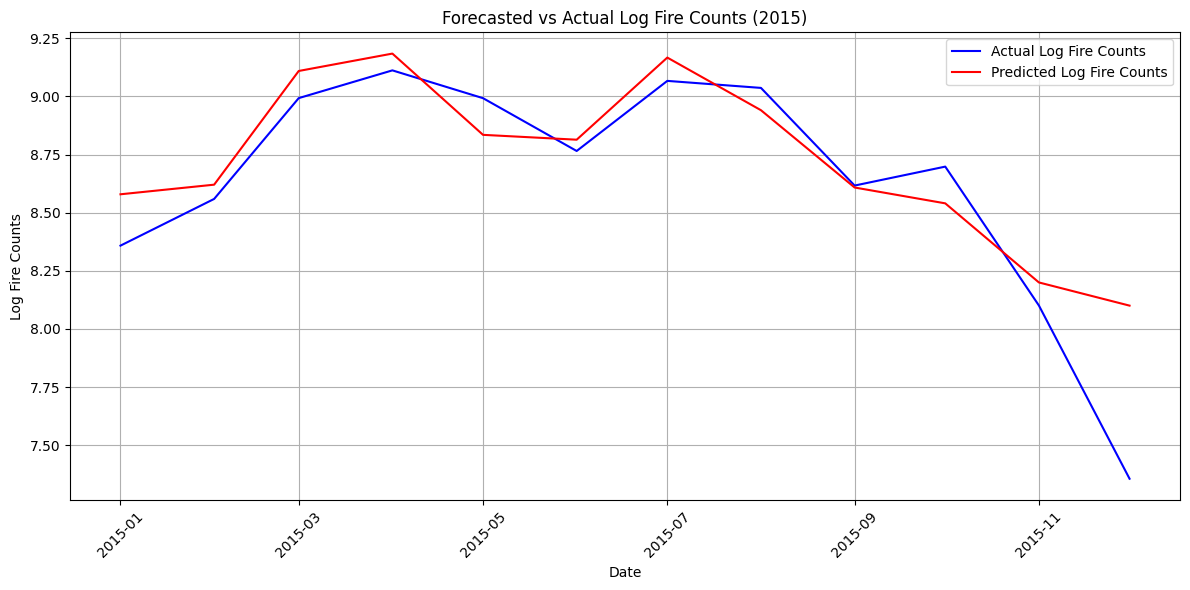

Forecasted vs Actual plot saved at: ./Abbildungen\forecast_vs_actual_2015.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import os

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Add logarithm of monthly fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Monthly Fire Counts'])

# Add lag features
n_lag = 12  # Number of lag months
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Split data into training (before 2015) and forecasting (2015) sets
train_data = data[data['YearMonth'] < '2015-01-01']
forecast_data = data[data['YearMonth'] >= '2015-01-01']

# Select features and target
features = ['MinTemperature', 'MaxTemperature', 'Inferred_Wind_Speed', 'Precipitation', 'Detrended_CO2', 'Detrended_O2', 'Month'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data for training
X_train = train_data[features].values
y_train = train_data[target].values

# Prepare the data for forecasting
X_forecast = forecast_data[features].values
y_forecast_actual = forecast_data[target].values

# Normalize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_forecast = scaler.transform(X_forecast)

# Reshape features for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_forecast = X_forecast.reshape(X_forecast.shape[0], X_forecast.shape[1], 1)

# Load the trained model
model_path = './Data_Waldbrand_Zeitreihen/Model_Results/forecastin_lstm_monthly_model_with_lags.keras'
model = load_model(model_path)

# Generate predictions for 2015
forecasted_log_fire_counts = model.predict(X_forecast).flatten()

# Create a DataFrame for actual and predicted values
forecast_results = pd.DataFrame({
    "Date": forecast_data['YearMonth'].values,
    "Actual": y_forecast_actual,
    "Predicted": forecasted_log_fire_counts
})

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(forecast_results["Date"], forecast_results["Actual"], label="Actual Log Fire Counts", color="blue")
plt.plot(forecast_results["Date"], forecast_results["Predicted"], label="Predicted Log Fire Counts", color="red")
plt.title("Forecasted vs Actual Log Fire Counts (2015)")
plt.xlabel("Date")
plt.ylabel("Log Fire Counts")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
output_dir = './Abbildungen'
os.makedirs(output_dir, exist_ok=True)
forecast_plot_path = os.path.join(output_dir, 'forecast_vs_actual_2015.png')
plt.savefig(forecast_plot_path, dpi=300)
plt.show()

print(f"Forecasted vs Actual plot saved at: {forecast_plot_path}")


## Gesamttabelle der Fehlerindizes aller Modelle.

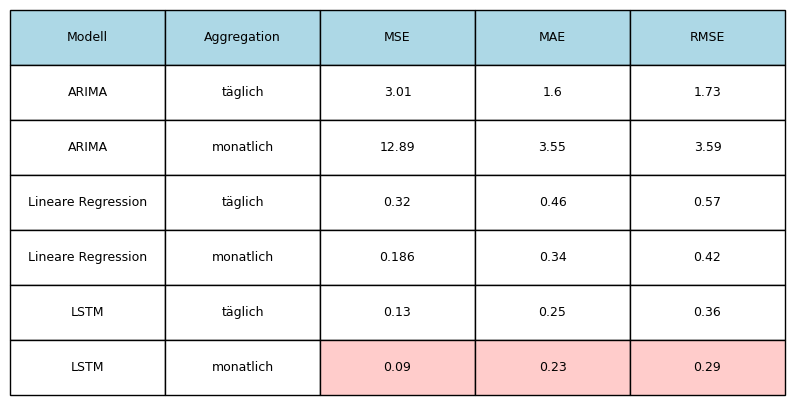

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten für die Tabelle
daten = {
    "Modell": ["ARIMA", "ARIMA", "Lineare Regression", "Lineare Regression", "LSTM", "LSTM"],
    "Aggregation": ["täglich", "monatlich", "täglich", "monatlich", "täglich", "monatlich"],
    "MSE": [3.01, 12.89, 0.32, 0.186, 0.13, 0.09],
    "MAE": [1.60, 3.55, 0.46, 0.34, 0.25, 0.23],
    "RMSE": [1.73, 3.59, 0.57, 0.42, 0.36, 0.29]
}

# Erstellen des DataFrames
df = pd.DataFrame(daten)

# Größere Skalierung
fig, ax = plt.subplots(figsize=(10, 5))  # Größere Darstellung
ax.axis('tight')
ax.axis('off')

# Tabelle erstellen
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])  # Weniger Rand

# Werte für LSTM monatlich hervorheben
highlight_rows = [5]  # Index der LSTM monatlich Zeile
highlight_cols = [2, 3, 4]  # MSE, MAE, RMSE Spalten

for row in highlight_rows:
    for col in highlight_cols:
        table[(row + 1, col)].set_facecolor('#ffcccb')  # Highlight Farbe

# Erste Zeile hervorheben (Index 1 für Tabelle mit Header)
for col in range(len(df.columns)):
    table[(0, col)].set_facecolor('#add8e6')  # Hellblau für Hervorhebung

# Tabelle als PNG speichern
plt.savefig("Abbildungen/tabelle_lstm_hervorgehoben.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
